# 1.5 Comparing ER, WS, BA Models with Real Ethereum Network

This notebook puts everything together.

We compare:

- **ER** (Erdős–Rényi random graph)
- **WS** (Watts–Strogatz small-world graph)
- **BA** (Barabási–Albert scale-free graph)
- **Real Ethereum Transaction Network**

using metrics:

1. Number of nodes and edges  
2. Average degree  
3. Connected components  
4. Clustering coefficient  
5. Average shortest path length  
6. Degree distribution (most important!)  

This analysis shows which theoretical model best matches Ethereum.

## 1. Import libraries


In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

from src.data.load_data import (
    load_clean_transactions,
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

tx = load_clean_transactions()
tx.head()


,hash,from_address,to_address,block_number,value,block_timestamp
0,0xd8ec648861cf4de73f18f9a034623eeded1b26ec7246...,0xa9264494a92ced04747ac84fc9ca5a0b9549b491,0x835033bd90b943fa0d0f8e5382d9dc568d3fbd96,23772289,4.699994e+19,2025-11-11 00:00:11+00:00
1,0x5843a9e865f9b7222ddb376ea2869c50b389c3a0d858...,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,0xc0ffeebabe5d496b2dde509f9fa189c25cf29671,23772292,5.817089e+19,2025-11-11 00:00:47+00:00
2,0x131571aec26cd23b0134a97341acf9fb0b559b085b68...,0xe50008c1d110da8e56982f46a9188a292ee90a7b,0x1ab4973a48dc892cd9971ece8e01dcc7688f8f23,23772292,3.390013e+18,2025-11-11 00:00:47+00:00
3,0xa1b7caf05dd498111a40ffe269fefb2ae574dde53da0...,0xe40d548eb4fa4d9188fd21723f2fd377456c0876,0x28c6c06298d514db089934071355e5743bf21d60,23772292,7.999922e+18,2025-11-11 00:00:47+00:00
4,0xc1d8e4ffa9e7864d5a38f84aa4532308d411ba35f82e...,0x0eb1665de6473c624dcd087fdeee27418d65ed59,0xa03400e098f4421b34a3a44a1b4e571419517687,23772292,6.318854e+18,2025-11-11 00:00:47+00:00


## 2. Build the real Ethereum graph (simple version)

In [3]:
# Build Ethereum graph (directed)
G_eth = nx.from_pandas_edgelist(
    tx,
    source="from_address",
    target="to_address",
    create_using=nx.DiGraph()
)

print("Ethereum graph built.")
print("Nodes:", G_eth.number_of_nodes())
print("Edges:", G_eth.number_of_edges())


Ethereum graph built.
Nodes: 7796
Edges: 9220


## 3. Build ER, WS, BA with similar scale

In [4]:
n_eth = G_eth.number_of_nodes()
avg_degree_eth = sum(dict(G_eth.degree()).values()) / n_eth

print("Ethereum N:", n_eth)
print("Ethereum avg degree:", avg_degree_eth)


Ethereum N: 7796
Ethereum avg degree: 2.365315546434069


In [5]:
# Set parameters
p = avg_degree_eth / (n_eth - 1)
k = int(avg_degree_eth)
m = max(1, k // 2)

print("ER p =", p)
print("WS k =", k)
print("BA m =", m)


ER p = 0.00030344009575805885
WS k = 2
BA m = 1


## 3.1 Generate ER / WS / BA graphs

In [6]:
sample_size = 50000  # you can reduce to 20000 if slow, in my case just fine with around 7000
sample_nodes = list(G_eth.nodes())[:sample_size]

# Induced subgraph of Ethereum
G_eth_sample = G_eth.subgraph(sample_nodes).copy()

n = G_eth_sample.number_of_nodes()
avg_k = sum(dict(G_eth_sample.degree()).values()) / n

print("Sample ETH nodes:", n)
print("Sample ETH avg degree:", avg_k)

# Build ER / WS / BA with similar scale
G_er = nx.erdos_renyi_graph(n=n, p=avg_k/n, seed=42)
G_ws = nx.watts_strogatz_graph(n=n, k=int(avg_k), p=0.05, seed=42)
G_ba = nx.barabasi_albert_graph(n=n, m=max(1, int(avg_k/2)), seed=42)


Sample ETH nodes: 7796
Sample ETH avg degree: 2.365315546434069


## 4. Compute structural metrics

In [9]:
def compute_stats(G, name="Graph"):
    G_u = G.to_undirected()
    degrees = [d for _, d in G_u.degree()]
    largest_cc = max(nx.connected_components(G_u), key=len)
    G_lcc = G_u.subgraph(largest_cc).copy()
    
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "avg_degree": np.mean(degrees),
        "max_degree": np.max(degrees),
        "components": nx.number_connected_components(G_u),
        "clustering": nx.average_clustering(G_u),
        "avg_path_len": nx.average_shortest_path_length(G_lcc)
    }

stats = {
    "ER": compute_stats(G_er),
    "WS": compute_stats(G_ws),
    "BA": compute_stats(G_ba),
    "Ethereum (sample)": compute_stats(G_eth_sample)
}

pd.DataFrame(stats).T


,nodes,edges,avg_degree,max_degree,components,clustering,avg_path_len
ER,7796.0,9091.0,2.332222,10.0,882.0,0.000162,10.106997
WS,7796.0,7796.0,2.000000,4.0,2.0,0.000000,308.886774
BA,7796.0,7795.0,1.999743,252.0,1.0,0.000000,8.496590
Ethereum (sample),7796.0,9220.0,2.357876,416.0,557.0,0.016090,6.197866


## 5. Degree distribution comparison 

In [ ]:
# extract degree sequences
deg_er = np.array([d for _, d in G_er.degree()])
deg_ws = np.array([d for _, d in G_ws.degree()])
deg_ba = np.array([d for _, d in G_ba.degree()])
deg_eth = np.array([d for _, d in G_eth_sample.degree()])


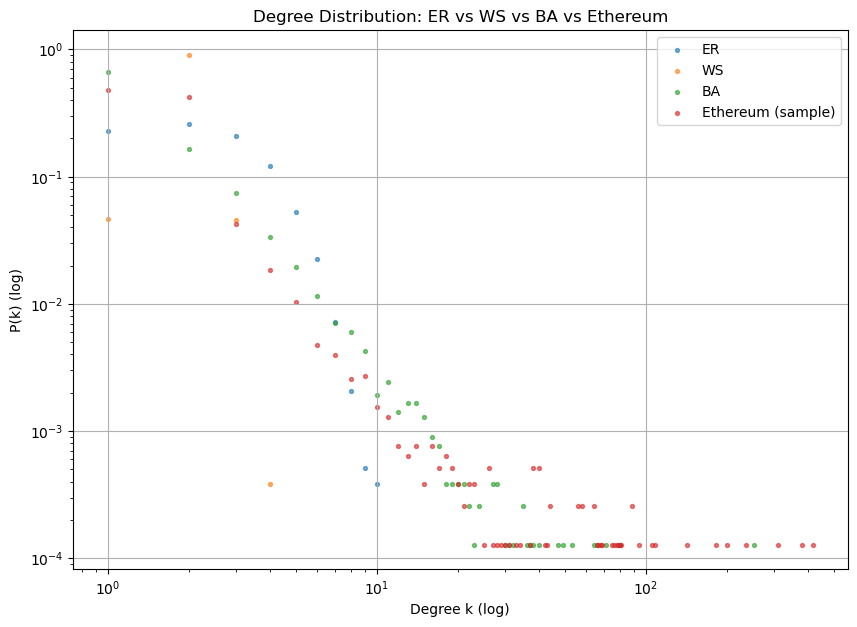

In [13]:
#Plot log-log degree distributions

plt.figure(figsize=(10,7))

for degrees, label in [
    (deg_er, "ER"),
    (deg_ws, "WS"),
    (deg_ba, "BA"),
    (deg_eth, "Ethereum (sample)")
]:
    counts = np.bincount(degrees)
    k = np.arange(len(counts))
    p_k = counts / counts.sum()
    
    plt.scatter(k[1:], p_k[1:], s=8, alpha=0.6, label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree k (log)")
plt.ylabel("P(k) (log)")
plt.title("Degree Distribution: ER vs WS vs BA vs Ethereum")
plt.legend()
plt.show()


# 6. Interpretation: Which model matches Ethereum?

## 1. ER (Random Graph)
- Degree distribution is narrow and Poisson-like.
- No hubs.
- Does **NOT** match Ethereum.

## 2. WS (Small-world Graph)
- High clustering.
- Degree distribution still narrow.
- Does **NOT** match Ethereum.

## 3. BA (Scale-free Graph)
- Degree distribution follows a **power-law**.
- Contains **large hubs** with extremely high degree.
- Very similar to Ethereum.

## 4. Real Ethereum Network
- Clear heavy-tailed degree distribution.
- Very high max-degree nodes:
  - Exchanges
  - Mining pools
  - MEV bots
  - Popular contracts (Uniswap, OpenSea, USDT)
- Structure matches a **scale-free network**.

---

# 🎯 Final Conclusion

> **Ethereum's transaction graph closely resembles a Barabási–Albert (BA) scale-free network.**  
>  
> It exhibits:
> - Power-law degree distribution  
> - Presence of extremely connected hubs  
> - Low clustering  
> - Short average path lengths  

This justifies using *scale-free network analysis* for:
- Whale detection  
- MEV bot detection  
- Community detection  
- Network vulnerability  
- Subgraph analysis  

This concludes Module 1.
